# Trupanion Assessment
<br>

  **Summary**
   
I chose to use a random forest model to predict next month claims. Random forests can handle the variety of data types, nonlinear relationships, and imbalances that appear in the dataset. They do not extrapolate time series trends very well so I modelled health care inflation with a linear regression and ran the random forest algorithm on the claims data after backing out the inflation trend.
    
I engineered several features from the provided data.
1. The age of the pet at each month: veterinary costs increase with age, and while the data provided the pet's age at enrollment, over time that data becomes less accurate.
<br>

2. Lagged healthcare claims: I included in the random forest model whether the pet had any claims in the last one, two and three months. I hypothesized that there might be some autocorrelation to the claims data. That appeared to be the case and the 1 month lagged claims data was the strongest predictor of next month claims that I was able to find.
    

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [79]:
#import both datasets
claim_data = pd.read_csv("claimdata.csv")
pet_data = pd.read_csv("petdata.csv")

#convert the dates to the datetime datatype
claim_data[['ClaimDate']] = claim_data[['ClaimDate']].apply(pd.to_datetime)
pet_data[['EnrollDate','CancelDate']] = pet_data[['EnrollDate','CancelDate']].apply(pd.to_datetime)

#join the pet data to the claims data so we can analyze them together.
df = claim_data.merge(pet_data,how='inner',on='PetId')
df[['ClaimDate','EnrollDate','CancelDate']] = df[['ClaimDate','EnrollDate','CancelDate']].apply(pd.to_datetime)

#take a quick look at our data

print(df.head(5))

   ClaimId  PetId  ClaimDate  ClaimAmount EnrollDate CancelDate Species  \
0        0   9273 2014-02-25       389.65 2013-01-01 2019-05-28     Dog   
1     1370   9273 2013-08-20       221.66 2013-01-01 2019-05-28     Dog   
2     1371   9273 2013-08-28       623.30 2013-01-01 2019-05-28     Dog   
3     1596   9273 2013-11-26       175.66 2013-01-01 2019-05-28     Dog   
4     1799   9273 2013-01-29       237.44 2013-01-01 2019-05-28     Dog   

         Breed               AgeAtEnroll  
0  Mixed Breed  8 weeks to 12 months old  
1  Mixed Breed  8 weeks to 12 months old  
2  Mixed Breed  8 weeks to 12 months old  
3  Mixed Breed  8 weeks to 12 months old  
4  Mixed Breed  8 weeks to 12 months old  


## Data Exploration ##



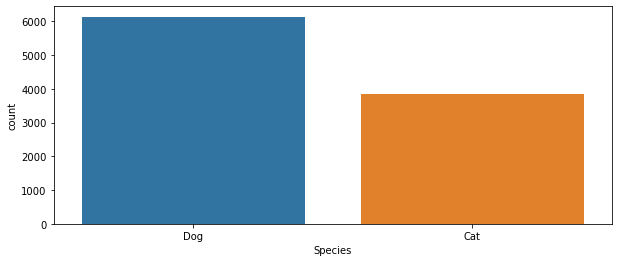

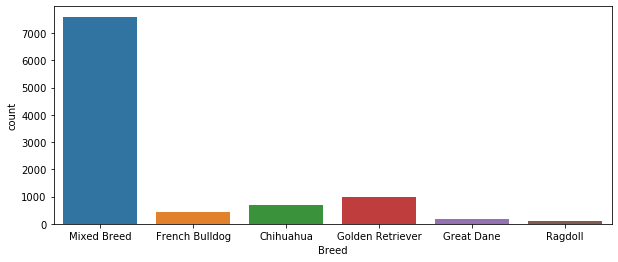

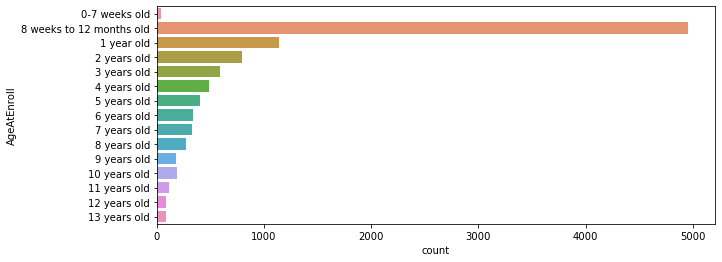

In [80]:

plt.figure(figsize=(10,4))
sns.countplot(x='Species',data=pet_data)
plt.show()
plt.figure(figsize=(10,4))
sns.countplot(x='Breed',data=pet_data)
plt.show()
plt.figure(figsize=(10,4))
sns.countplot(y='AgeAtEnroll',data=pet_data,order=['0-7 weeks old', '8 weeks to 12 months old', '1 year old', \
                                             '2 years old', '3 years old', '4 years old', '5 years old', \
                                             '6 years old', '7 years old', '8 years old', '9 years old', \
                                             '10 years old', '11 years old', '12 years old', '13 years old'])
plt.show()


### Inflation##
<br> This next cell investigates whether cost inflation is present in the claims data. While the random forest algorithm can do a good job of predicting within its range, it has difficulty extrapolating. As a result, I model inflation separately from the random forest model.

<br> 

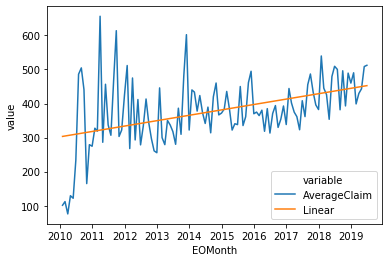

In [81]:
#Create a series of month end dates
df['EOMonth'] = df.ClaimDate + pd.tseries.offsets.MonthEnd(0)

#Create a dataframe with the average claim amount at each month. 
inflation_df=pd.DataFrame()
inflation_df = df[['ClaimAmount','EOMonth']].groupby(by=['EOMonth']).sum()/df[['ClaimAmount','EOMonth']].groupby(by=['EOMonth']).count()
inflation_df.reset_index(inplace=True)
inflation_df.rename(columns={'ClaimAmount':'AverageClaim'},inplace=True)

#Create a series of date differences in days. 
x = pd.DataFrame((inflation_df['EOMonth'] - inflation_df['EOMonth'].iloc[0]).dt.days)

#Create a series for the average cost of each claim at each month
y = pd.DataFrame(inflation_df.AverageClaim).values.reshape(-1,1)

#run regression to estimate inflation
reg = LinearRegression().fit(x,y)

#add best fit line to the inflation dataframe for visualizing
inflation_df['Linear'] = reg.intercept_ + reg.coef_[0][0] * x

#plot average claim each month over time
sns.lineplot(x='EOMonth', y='value', hue='variable',data=pd.melt(inflation_df, ['EOMonth']))

#add the inflation factor to the dataframe
inflation_df['AdjustmentFactor'] = inflation_df['Linear']/reg.intercept_[0]

## Data Formatting##

The next cell formats the data so that a random forest model can be trained on it. In order to predict claims for each pet next month, the model is being trained on previous month data. Most pets owners don't file a claim every month so all that data is missing from the dataset. As a result, if a PetId has an open policy but no claims, it needs to be added to the training set as $0 for next month's claim. 


In [82]:
#Create a list of dates to loop through
dates = pd.date_range(min(df.EnrollDate),'2019-06-30',freq='M')

#Create a dataframe 'dflist' and loop through every month end and append to the dataframe all the 
#PetIds that haven't been cancelled by that point in time. I also add a 'reference' column to the dataframe which
#is the month end and will make it easier to groupby. 
dflist = pd.DataFrame()
for i in dates:
    temp=pet_data[(pet_data.EnrollDate <= i) & ((pet_data.CancelDate > i) | (pet_data.CancelDate.isnull()))].copy()
    temp['reference'] = i
    dflist = pd.concat([dflist, temp])

#There are a total of 304,286 open policy months in the entire dataset. 
#We also know the total number of claims is 37,049 so in almost 90% of months a pet will not have a claim.
print(dflist.shape[0])

print(dflist.head(5))

314150
      PetId EnrollDate CancelDate Species           Breed  \
182     182 2009-11-30 2010-02-10     Dog     Mixed Breed   
1739   1739 2009-11-25 2010-03-25     Dog  French Bulldog   
1790   1790 2009-11-20 2010-01-13     Cat     Mixed Breed   
2298   2298 2009-11-24 2018-08-06     Dog     Mixed Breed   
2826   2826 2009-11-24 2011-09-07     Dog     Mixed Breed   

                   AgeAtEnroll  reference  
182                2 years old 2009-11-30  
1739               4 years old 2009-11-30  
1790               6 years old 2009-11-30  
2298  8 weeks to 12 months old 2009-11-30  
2826  8 weeks to 12 months old 2009-11-30  


In [83]:
#Because some pets will have multiple claims per month, I want to make sure to group them by month end so 
#multiple claims submitted for a pet in a single month are accounted for. 
claim_data['reference'] = claim_data['ClaimDate'] + pd.tseries.offsets.MonthEnd(-1)

new_claim = claim_data[['reference','PetId','ClaimAmount']].groupby(['reference','PetId']).sum()
dflist = dflist.merge(new_claim['ClaimAmount'], how='left',left_on=['PetId','reference'],right_on=['PetId','reference'],suffixes=('', '_y'))
dflist.drop(list(dflist.filter(regex='_y$')), axis=1, inplace=True)

print(dflist.columns)
print(dflist.head(5))

Index(['PetId', 'EnrollDate', 'CancelDate', 'Species', 'Breed', 'AgeAtEnroll',
       'reference', 'ClaimAmount'],
      dtype='object')
   PetId EnrollDate CancelDate Species           Breed  \
0    182 2009-11-30 2010-02-10     Dog     Mixed Breed   
1   1739 2009-11-25 2010-03-25     Dog  French Bulldog   
2   1790 2009-11-20 2010-01-13     Cat     Mixed Breed   
3   2298 2009-11-24 2018-08-06     Dog     Mixed Breed   
4   2826 2009-11-24 2011-09-07     Dog     Mixed Breed   

                AgeAtEnroll  reference  ClaimAmount  
0               2 years old 2009-11-30          NaN  
1               4 years old 2009-11-30          NaN  
2               6 years old 2009-11-30          NaN  
3  8 weeks to 12 months old 2009-11-30          NaN  
4  8 weeks to 12 months old 2009-11-30          NaN  


In [84]:
#Last I reduce the claims amount by the inflation factor.
dflist['ClaimAmount'].fillna(0,inplace=True)
dflist['AdjustmentFactor'] = ((dflist['reference'] - pd.Timestamp('2009-12-31')).dt.days * \
                                                  reg.coef_[0][0]+reg.intercept_)/reg.intercept_

dflist['AdjustedClaims'] = dflist['ClaimAmount']/dflist['AdjustmentFactor']



## Feature Engineering##

I created four additional features. The first is the age of the pet at each month in years. The other three are the lagged 1, 2, and 3, months claims for each pet. 

In [85]:
#add in the Age column, rather breaking it into factors. 
agedict = {'0-7 weeks old': 0.07, '8 weeks to 12 months old': 0.19, '1 year old': 1, \
           '2 years old': 2, '3 years old': 3, '4 years old': 4, '5 years old': 5, \
           '6 years old': 6, '7 years old': 7, '8 years old': 8, '9 years old': 9, \
           '10 years old': 10, '11 years old': 11, '12 years old': 12, '13 years old': 13}

dflist['NumericalAgeAtEnroll'] = dflist['AgeAtEnroll'].map(agedict)
dflist['CurrentAge'] = dflist['NumericalAgeAtEnroll'] + ((dflist['reference'] - dflist['EnrollDate'])/pd.Timedelta(days=365))

print(dflist.columns)

Index(['PetId', 'EnrollDate', 'CancelDate', 'Species', 'Breed', 'AgeAtEnroll',
       'reference', 'ClaimAmount', 'AdjustmentFactor', 'AdjustedClaims',
       'NumericalAgeAtEnroll', 'CurrentAge'],
      dtype='object')


In [86]:
#1m lag
temptable = dflist[['reference','PetId','AdjustedClaims']].copy()
temptable['reference'] = temptable['reference'] + pd.tseries.offsets.MonthEnd(1)
result = pd.merge(dflist, temptable, how='left', on=['reference', 'PetId'])
result = result.rename(columns={'AdjustedClaims_x':'AdjustedClaims','AdjustedClaims_y':'lag1m'})
dflist = result.copy()

#2month lag
temptable = dflist[['reference','PetId','AdjustedClaims']].copy()
temptable['reference'] = temptable['reference'] + pd.tseries.offsets.MonthEnd(2)
result = pd.merge(dflist, temptable, how='left', on=['reference', 'PetId'])
result = result.rename(columns={'AdjustedClaims_x':'AdjustedClaims','AdjustedClaims_y':'lag2m'})
dflist = result.copy()

#3m lag
temptable = dflist[['reference','PetId','AdjustedClaims']].copy()
temptable['reference'] = temptable['reference'] + pd.tseries.offsets.MonthEnd(3)
result = pd.merge(dflist, temptable, how='left', on=['reference', 'PetId'])
result = result.rename(columns={'AdjustedClaims_x':'AdjustedClaims','AdjustedClaims_y':'lag3m'})
dflist = result.copy()

dflist.lag1m.fillna(0,inplace=True)
dflist.lag2m.fillna(0,inplace=True)
dflist.lag3m.fillna(0,inplace=True)

print(dflist.columns)

Index(['PetId', 'EnrollDate', 'CancelDate', 'Species', 'Breed', 'AgeAtEnroll',
       'reference', 'ClaimAmount', 'AdjustmentFactor', 'AdjustedClaims',
       'NumericalAgeAtEnroll', 'CurrentAge', 'lag1m', 'lag2m', 'lag3m'],
      dtype='object')


## Dummy Variables ##

Sklearn requires its the training set use one-hot encoding for categorical variables. I can use the get_dummies() method in pandas to convert the Species and Breed variables into dummy variables. 

In [87]:
dummy=pd.get_dummies(dflist['Species'])
dflist = pd.concat([dflist,dummy],axis=1)

dummy=pd.get_dummies(dflist['Breed'])
dflist = pd.concat([dflist,dummy],axis=1)

#double check we have a new column for each variable. 
dflist = dflist.loc[:, ~dflist.columns.duplicated()]
print(dflist.columns)

Index(['PetId', 'EnrollDate', 'CancelDate', 'Species', 'Breed', 'AgeAtEnroll',
       'reference', 'ClaimAmount', 'AdjustmentFactor', 'AdjustedClaims',
       'NumericalAgeAtEnroll', 'CurrentAge', 'lag1m', 'lag2m', 'lag3m', 'Cat',
       'Dog', 'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane',
       'Mixed Breed', 'Ragdoll'],
      dtype='object')


## Train Model##


0.03301780390550779


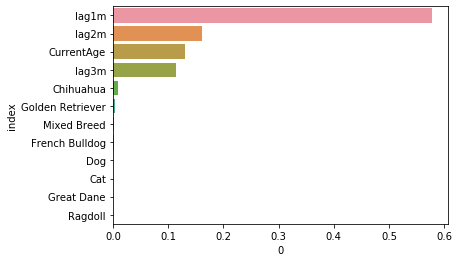

In [90]:
#initialize random forest parameters
rf = RandomForestRegressor(max_depth=5, random_state=0,oob_score=True)

#set variables we want to use
x_vars=['lag1m','lag2m','lag3m','CurrentAge', 'Cat','Dog', 'Chihuahua','French Bulldog', 'Golden Retriever', 'Great Dane','Mixed Breed', 'Ragdoll']
y_vars=['AdjustedClaims']


#strip out data as of 2019-06-30, this is the data we want to predict so we don't want to train
#or model on this data. They were included in the dflist so that our feature engineering would not have to 
#repeat our feature engineering process.
x= dflist.loc[~dflist.reference.isin(['2019-06-30']),x_vars]
y = dflist.loc[~dflist.reference.isin(['2019-06-30']),y_vars]
y = y.AdjustedClaims.ravel()

#fit the model
rf.fit(x,y)

print(rf.oob_score_)

#The most important features in our model are our engineer variables, specifically last month's claim.
featureimportance = pd.DataFrame(rf.feature_importances_,x_vars).reset_index().sort_values(by=0,ascending=False)
sns.barplot(x=0,y='index', data=featureimportance)

While the out-of-bag MSE score of this model is only 0.033, our engineered features are the most significant features which suggests that we have made progress from the original dataset. In order to continue to make improvements, we would need to add more features or use another approach. Random forest is generally robust so it's not clear what algorithm could offer significant improvements, maybe panel regression.

## Predictions

      PetId  PredictedClaim
0         2           29.42
1         4           27.36
2         7           27.53
3         8           27.53
4        15           36.66
...     ...             ...
4944   9990           27.36
4945   9991           36.66
4946   9992           38.26
4947   9995          115.92
4948   9998           27.36

[4949 rows x 2 columns]


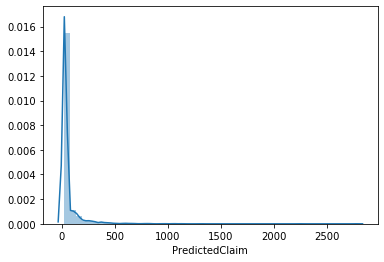

In [91]:
#predict next month's adjusted claims
predict = dflist[dflist.reference=='2019-06-30'].loc[:,x_vars].copy()
AdjClaimPred = rf.predict(predict)
predict['AdjClaimPred'] = AdjClaimPred
predict[['PetId','AdjustmentFactor']] = dflist[dflist.reference=='2019-06-30'].loc[:,['PetId','AdjustmentFactor']].copy()

#Factor inflation back into the adjusted claims. 
predict['PredictedClaim'] = round(predict.AdjustmentFactor * predict.AdjClaimPred,2)


sns.distplot(predict.PredictedClaim)

final_predictions = predict[['PetId','PredictedClaim']].reset_index(drop=True).copy()

print(final_predictions)



# Conclusion

Some potential improvements and alternatives:
1. Use an ARIMA model to estimate inflation rather than a linear model
2. Split off a validation set and conduct more detailed cross validation
3. Turn the problem into a binary classification problem (claim or no claim), and create another model that estimates the claim amount if there is a claim
4. Make use of over or undersampling considering the dataset is fairly imbalanced
5. Ensemble with panel regression since they are different types of models